In [32]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Set notebook mode to work in offline
#pyo.init_notebook_mode()


#configure_plotly_browser_state()

# pyo.init_notebook_mode(connected=True)

In [11]:
from solver import deasolver

In [ ]:
dea_types = ["IO_VRS", "OO_CRS", "OO_VRS", "IO_CRS"]
dea_list = ["US22", "S22","US55","S55"]

for t in dea_list:
    
    exec(f"{t} = pd.read_excel('Data/{t}.xlsx', index_col=0)")
    
    for i, d in enumerate(dea_types):
        
        exec(f"{t}_{d} = pd.read_excel('Data/{t}_Solution.xlsx', index_col=0, header=[1], nrows=1000, skiprows = i * 1000 + i * 2)")
        

In [9]:
df = pd.read_excel('Data/US22.xlsx', index_col=0)
df

,Input 1,Input 2,Output 1,Output 2
DMU 0001,397.02,265.18,379.02,537.61
DMU 0002,312.53,209.89,580.46,507.01
DMU 0003,430.04,360.20,556.75,452.77
DMU 0004,473.96,314.18,590.20,383.22
DMU 0005,472.91,211.27,534.18,359.94
...,...,...,...,...
DMU 0996,577.89,422.77,373.71,260.54
DMU 0997,588.60,296.17,484.61,306.23
DMU 0998,567.06,240.43,398.60,354.88
DMU 0999,543.52,337.50,413.00,343.68


In [12]:
deasolver(inputfile = 'Data/US22.xlsx', folder = "Data/New/", out_suffix1="_Sol")

Restricted license - for non-production use only - expires 2023-10-25
20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


### US22_IO_VRS 

In [13]:
X = df
X.head()

,Input 1,Input 2,Output 1,Output 2
DMU 0001,397.02,265.18,379.02,537.61
DMU 0002,312.53,209.89,580.46,507.01
DMU 0003,430.04,360.20,556.75,452.77
DMU 0004,473.96,314.18,590.20,383.22
DMU 0005,472.91,211.27,534.18,359.94


In [19]:
y = pd.read_excel('Data/New/US22_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

,Efficiency_Scores
DMU 0001,0.600978
DMU 0002,1.000000
DMU 0003,0.658441
DMU 0004,0.627703
DMU 0005,0.634704


In [20]:
scaler = StandardScaler()
reg_model = LinearRegression()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0014786285743130833
neg_root_mean_squared_error: -0.03832085223374597
r2: 0.896637479317733


In [25]:
std_scaler = StandardScaler()
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

grid = RandomizedSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.00212092400549763
neg_root_mean_squared_error: -0.04572846650641612
r2: 0.8516864675378748
grid.best_score:  -0.05397230371877827
grid.best_params:  {'decisiontreeregressor__min_samples_split': 20, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': 12}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=12, min_samples_split=20,
                                       random_state=42))])
grid.r2:  0.7941288149468356


In [27]:
reg_model = KNeighborsRegressor()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0012232016151015896
neg_root_mean_squared_error: -0.034759083986650834
r2: 0.9149683859815927


In [28]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0009193799533976997
neg_root_mean_squared_error: -0.02991014505864048
r2: 0.9362330398408458
grid.best_score:  -0.030432328379192363
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
grid.r2:  0.9340893365261234


In [29]:
std_scaler = StandardScaler()
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0005804748180187318
neg_root_mean_squared_error: -0.023843069221982715
r2: 0.9597559770842639
-0.01608947101075628
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           n_estimators=1000, random_state=42,
                                           subsample=0.3))])
r2: 0.9809580211074799


In [33]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.000813391986637248
neg_root_mean_squared_error: -0.02825676167146702
r2: 0.9430875095807304
grid.best_score:  -0.02665334521111078
grid.best_params:  {'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7999999999999999, 'xgbregressor__colsample_bylevel': 0.6}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=0.7999999999999999,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=5,
                              m

In [34]:
std_scaler = StandardScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -8.093888154576086e-05
neg_root_mean_squared_error: -0.008984569400553952
r2: 0.9943519107785523


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.6760,0.6741,0.0019,0.2842,True
1,0.5995,0.6095,-0.0100,-1.6425,True
2,0.5306,0.5366,-0.0061,-1.1304,True
3,0.4849,0.4914,-0.0064,-1.3074,True
4,0.8679,0.8508,0.0171,2.0123,True
...,...,...,...,...,...
195,0.2811,0.2890,-0.0078,-2.7077,True
196,0.5980,0.6001,-0.0022,-0.3589,True
197,0.5198,0.5207,-0.0009,-0.1740,True
198,0.4969,0.4967,0.0003,0.0531,True


In [36]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

191


9

In [37]:
print(res.describe())

       Prediction      Actual        Diff  Error_Perc
count  200.000000  200.000000  200.000000  200.000000
mean     0.575814    0.575345    0.000468    0.035198
std      0.120881    0.118975    0.008578    1.402844
min      0.281100    0.289000   -0.027200   -3.710900
25%      0.487850    0.490575   -0.004750   -0.900600
50%      0.570150    0.571150   -0.000500   -0.078600
75%      0.656050    0.655225    0.004225    0.721325
max      1.039400    1.000000    0.039400    5.851200


In [38]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9974
p-Value 0.0


In [39]:
res.to_excel("Data/New/US22_ML.xlsx", index=False)

In [40]:
res = pd.read_excel("Data/New/US22_ML.xlsx")

In [45]:
res.loc[res["Prediction"]>1, "Prediction"] = 1

In [47]:
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.6760,0.6741,0.0019,0.2819,True
1,0.5995,0.6095,-0.0100,-1.6407,True
2,0.5306,0.5366,-0.0060,-1.1182,True
3,0.4849,0.4914,-0.0065,-1.3228,True
4,0.8679,0.8508,0.0171,2.0099,True
...,...,...,...,...,...
195,0.2811,0.2890,-0.0079,-2.7336,True
196,0.5980,0.6001,-0.0021,-0.3499,True
197,0.5198,0.5207,-0.0009,-0.1728,True
198,0.4969,0.4967,0.0002,0.0403,True


In [48]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

192


8

In [49]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9974
p-Value 0.0


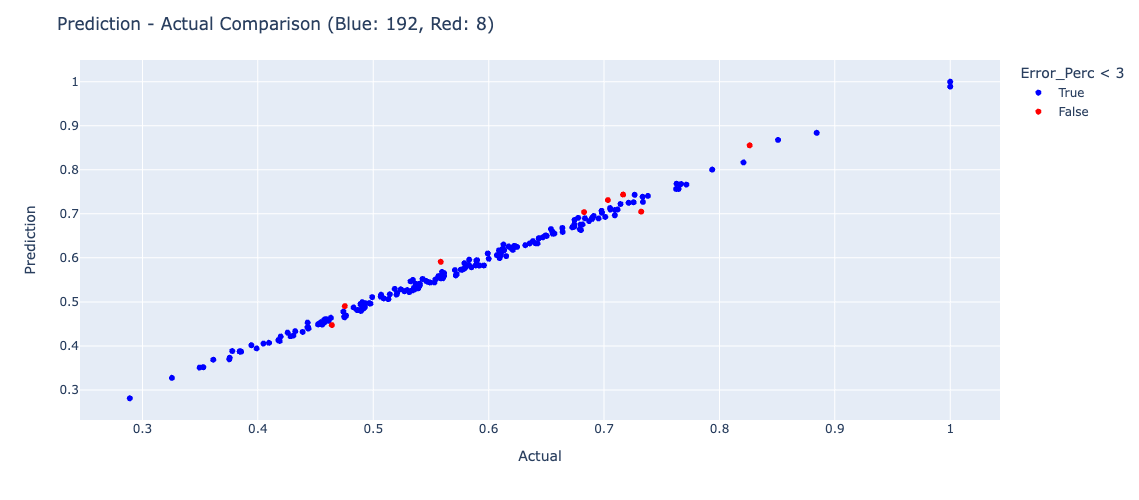

In [50]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train, batch_size = 32, epochs = 1000, verbose=1)

In [52]:
print("mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test)))
print("neg_mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test), squared=False))
print("r2:", r2_score(y_test, ann.predict(X_test)))

mean_squared_error: 4.350279174895706e-05
neg_mean_squared_error: 0.006595664617683123
r2: 0.9969113075140379


In [53]:
prediction = ann.predict(X_test)

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3 
res_ann = res_ann.round(4)

res_ann

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.6741,0.6741,0.0000,0.0064,True
1,0.6060,0.6095,-0.0035,-0.5796,True
2,0.5379,0.5366,0.0012,0.2286,True
3,0.4916,0.4914,0.0003,0.0557,True
4,0.8504,0.8508,-0.0003,-0.0406,True
...,...,...,...,...,...
195,0.3225,0.2890,0.0335,11.6046,False
196,0.5974,0.6001,-0.0027,-0.4560,True
197,0.5211,0.5207,0.0004,0.0728,True
198,0.4923,0.4967,-0.0044,-0.8785,True


In [54]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

195


5

In [55]:
res_ann.describe()

,Prediction,Actual,Diff,Error_Perc
count,200.000000,200.000000,200.000000,200.000000
mean,0.573726,0.575345,-0.001623,-0.170847
std,0.115730,0.118975,0.006409,1.278543
min,0.322500,0.289000,-0.051200,-5.120400
25%,0.487675,0.490575,-0.003825,-0.629975
50%,0.568600,0.571150,-0.001900,-0.316350
75%,0.651300,0.655225,0.000425,0.076275
max,0.967800,1.000000,0.033500,11.604600


In [56]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9996
p-Value 0.0


In [57]:
res_ann.to_excel("Data/New/US22_DL.xlsx", index=False)

In [197]:
res_ann = pd.read_excel("Data/New/US22_DL.xlsx")

In [198]:
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1

In [199]:
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3  
res_ann = res_ann.round(4)

In [200]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

195


5

In [201]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9996
p-Value 0.0


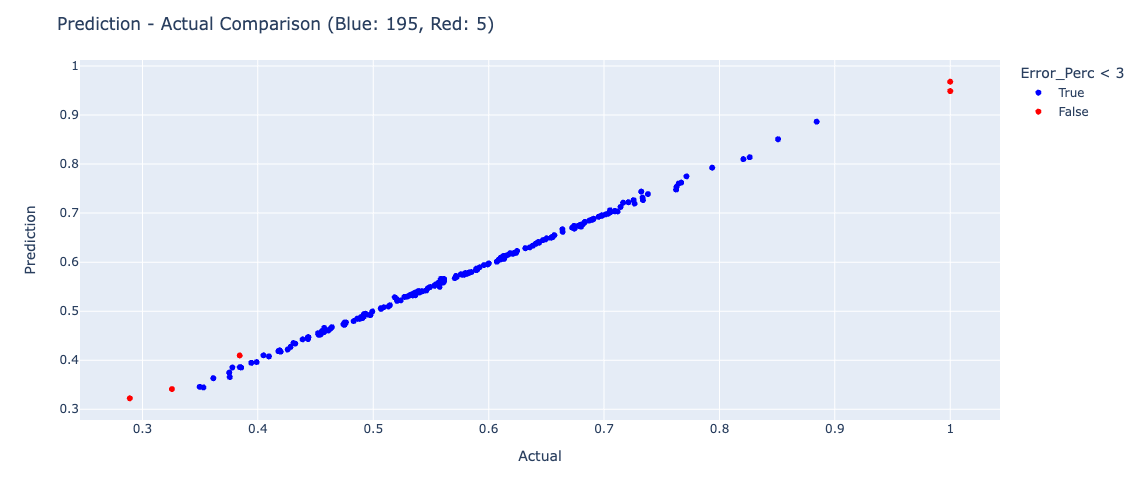

In [202]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### S22_IO_VRS 

In [65]:
df = pd.read_excel('Data/S22.xlsx', index_col=0)
df

,Input 1,Input 2,Output 1,Output 2
DMU 0001,110.03,366.95,98.95,697.08
DMU 0002,128.76,153.40,101.17,590.34
DMU 0003,126.43,412.75,91.89,513.49
DMU 0004,123.73,395.73,98.75,423.26
DMU 0005,114.73,333.32,110.78,444.36
...,...,...,...,...
DMU 0996,108.97,779.45,108.62,449.08
DMU 0997,107.07,536.50,107.17,383.14
DMU 0998,98.89,496.85,110.73,478.94
DMU 0999,107.83,593.94,105.72,482.97


In [66]:
deasolver(inputfile = 'Data/S22.xlsx', folder = "Data/New/", out_suffix1="_Sol")

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [68]:
X = df
X.head()

,Input 1,Input 2,Output 1,Output 2
DMU 0001,110.03,366.95,98.95,697.08
DMU 0002,128.76,153.40,101.17,590.34
DMU 0003,126.43,412.75,91.89,513.49
DMU 0004,123.73,395.73,98.75,423.26
DMU 0005,114.73,333.32,110.78,444.36


In [69]:
y = pd.read_excel('Data/New/S22_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

,Efficiency_Scores
DMU 0001,0.809955
DMU 0002,0.698887
DMU 0003,0.595224
DMU 0004,0.620998
DMU 0005,0.757204


In [70]:
scaler = StandardScaler()
reg_model = LinearRegression()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0005065048526695653
neg_root_mean_squared_error: -0.022344933713575273
r2: 0.9159231797434245


In [71]:
std_scaler = StandardScaler()
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

grid = RandomizedSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0006969555949075771
neg_root_mean_squared_error: -0.02635253468101285
r2: 0.8833075423548408
grid.best_score:  -0.03277342513079181
grid.best_params:  {'decisiontreeregressor__min_samples_split': 30, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': 13}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=13, min_samples_split=30,
                                       random_state=42))])
grid.r2:  0.8218399402375269


In [72]:
reg_model = KNeighborsRegressor()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0003838467521670874
neg_root_mean_squared_error: -0.01946375527764245
r2: 0.9374913479707988


In [73]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0002734266923873261
neg_root_mean_squared_error: -0.01642250851565242
r2: 0.954833730842984
grid.best_score:  -0.017080737431197805
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
grid.r2:  0.9509388441164462


In [74]:
std_scaler = StandardScaler()
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.00014356654188630468
neg_root_mean_squared_error: -0.011962833851319151
r2: 0.976070170125305
-0.008188048662941209
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 1000, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           n_estimators=1000, random_state=42,
                                           subsample=0.3))])
r2: 0.9888462879884319


In [75]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.00019021371679044406
neg_root_mean_squared_error: -0.013713661060189907
r2: 0.9686741187647308
grid.best_score:  -0.011419544243685695
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999,
                              colsample_bynode=1, colsample_bytree=0.7,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=6,
                              min_child_we

In [76]:
std_scaler = StandardScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -3.644465597095435e-05
neg_root_mean_squared_error: -0.0059808655803548025
r2: 0.9939808182021288


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.7744,0.7738,0.0006,0.0827,True
1,0.6636,0.6656,-0.0020,-0.3053,True
2,0.7261,0.7279,-0.0018,-0.2441,True
3,0.7719,0.7737,-0.0018,-0.2270,True
4,0.8204,0.8322,-0.0118,-1.4161,True
...,...,...,...,...,...
195,0.7748,0.7338,0.0411,5.5978,False
196,0.7237,0.7252,-0.0015,-0.2017,True
197,0.7683,0.7609,0.0074,0.9660,True
198,0.7559,0.7576,-0.0017,-0.2192,True


In [78]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

199


1

In [79]:
print(res.describe())

       Prediction      Actual        Diff  Error_Perc
count  200.000000  200.000000  200.000000  200.000000
mean     0.753709    0.753720   -0.000007    0.014281
std      0.075180    0.076336    0.006030    0.776361
min      0.573300    0.571000   -0.027900   -2.871200
25%      0.706975    0.708100   -0.003300   -0.417000
50%      0.753300    0.751300   -0.000700   -0.097050
75%      0.804625    0.805950    0.003000    0.412625
max      0.991900    1.000000    0.041100    5.597800


In [80]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.996
p-Value 0.0


In [81]:
res.to_excel("Data/New/S22_ML.xlsx", index=False)

In [82]:
res = pd.read_excel("Data/New/S22_ML.xlsx")

In [83]:
res.loc[res["Prediction"]>1, "Prediction"] = 1

In [84]:
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)

In [85]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

199


1

In [86]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.996
p-Value 0.0


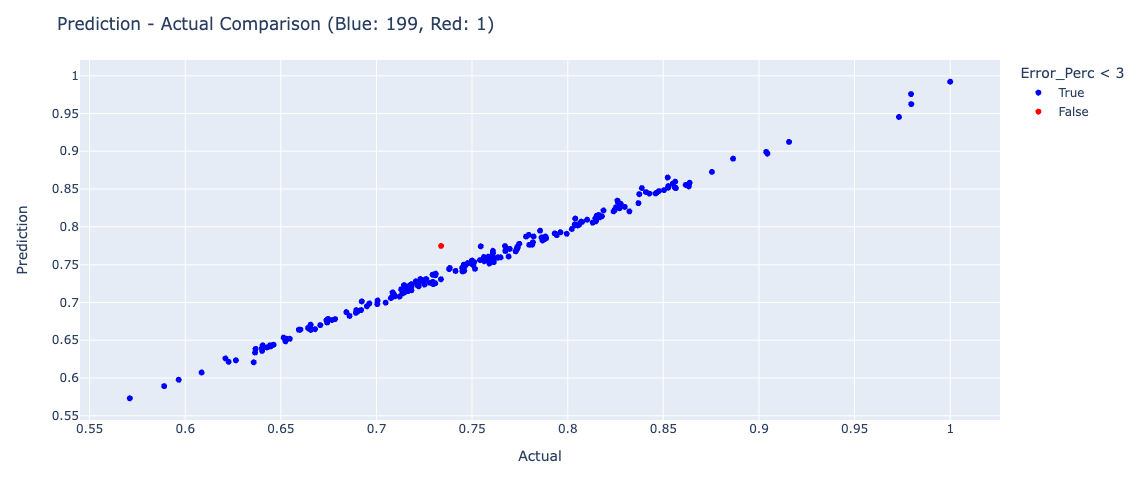

In [87]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train, batch_size = 32, epochs = 1000, verbose=1)

In [89]:
print("mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test)))
print("neg_mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test), squared=False))
print("r2:", r2_score(y_test, ann.predict(X_test)))

mean_squared_error: 2.7382789719970204e-05
neg_mean_squared_error: 0.005232856745599883
r2: 0.9952775066983444


In [90]:
prediction = ann.predict(X_test)

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3 
res_ann = res_ann.round(4)

res_ann

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.7774,0.7738,0.0036,0.4597,True
1,0.6696,0.6656,0.0039,0.5907,True
2,0.7291,0.7279,0.0012,0.1618,True
3,0.7758,0.7737,0.0021,0.2693,True
4,0.8339,0.8322,0.0017,0.2013,True
...,...,...,...,...,...
195,0.7430,0.7338,0.0092,1.2586,True
196,0.7264,0.7252,0.0012,0.1722,True
197,0.7641,0.7609,0.0032,0.4159,True
198,0.7622,0.7576,0.0046,0.6058,True


In [91]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

199


1

In [92]:
res_ann.describe()

,Prediction,Actual,Diff,Error_Perc
count,200.000000,200.000000,200.000000,200.000000
mean,0.756041,0.753720,0.002322,0.322673
std,0.075640,0.076336,0.004701,0.591427
min,0.581700,0.571000,-0.027700,-2.766500
25%,0.708525,0.708100,0.000800,0.112150
50%,0.753100,0.751300,0.002500,0.329150
75%,0.807600,0.805950,0.003925,0.534275
max,0.999700,1.000000,0.026800,4.212700


In [93]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.999
p-Value 0.0


In [94]:
res_ann.to_excel("Data/New/S22_DL.xlsx", index=False)

In [191]:
res_ann = pd.read_excel("Data/New/S22_DL.xlsx")

In [192]:
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1

In [193]:
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3  
res_ann = res_ann.round(4)

In [194]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

199


1

In [195]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.999
p-Value 0.0


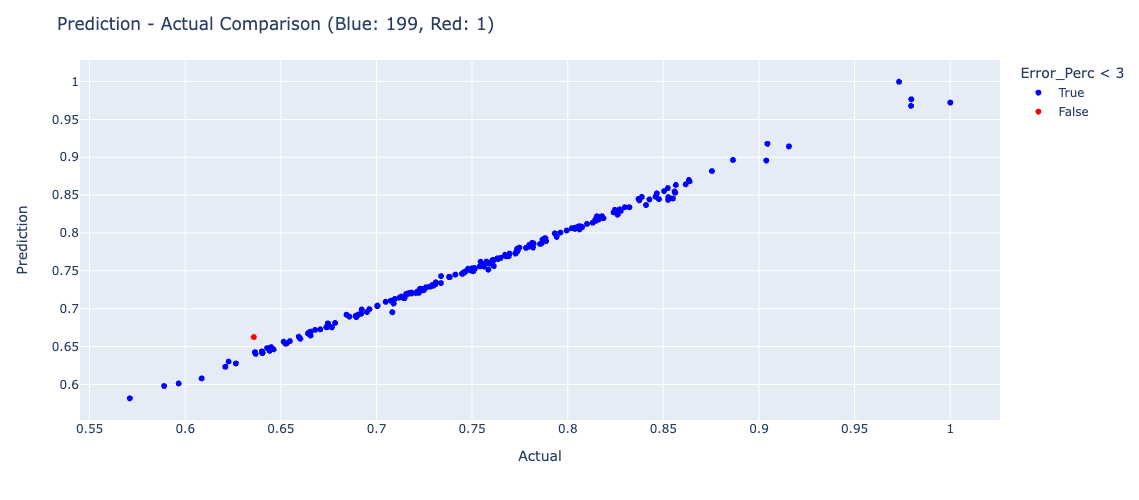

In [196]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### US55_IO_VRS 

In [101]:
df = pd.read_excel('Data/US55.xlsx', index_col=0)
df

,Input 1,Input 2,Input 3,Input 4,Input 5,Output 1,Output 2,Output 3,Output 4,Output 5
DMU 0001,262.93,368.02,311.81,369.14,158.95,373.54,165.68,625.17,620.95,193.29
DMU 0002,267.81,449.71,300.84,194.85,195.14,312.06,154.78,360.41,510.36,291.05
DMU 0003,315.52,467.64,249.35,285.36,251.24,224.69,214.17,333.71,378.87,180.60
DMU 0004,273.62,219.07,245.76,379.23,164.55,345.12,200.72,466.64,560.33,172.56
DMU 0005,323.65,298.21,369.23,380.81,117.59,406.04,218.08,513.41,583.01,152.26
...,...,...,...,...,...,...,...,...,...,...
DMU 0996,278.92,497.34,292.40,263.17,253.21,349.98,194.55,220.20,296.03,221.31
DMU 0997,302.55,554.88,339.71,409.44,163.39,378.89,279.95,437.76,463.17,138.70
DMU 0998,288.62,519.41,302.51,257.01,243.24,275.98,274.91,275.49,340.32,211.50
DMU 0999,347.93,329.13,187.08,195.77,257.11,293.60,188.74,248.37,516.16,298.74


In [102]:
deasolver(inputfile = 'Data/US55.xlsx', folder = "Data/New/", out_suffix1="_Sol")

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [103]:
X = df
X.head()

,Input 1,Input 2,Input 3,Input 4,Input 5,Output 1,Output 2,Output 3,Output 4,Output 5
DMU 0001,262.93,368.02,311.81,369.14,158.95,373.54,165.68,625.17,620.95,193.29
DMU 0002,267.81,449.71,300.84,194.85,195.14,312.06,154.78,360.41,510.36,291.05
DMU 0003,315.52,467.64,249.35,285.36,251.24,224.69,214.17,333.71,378.87,180.60
DMU 0004,273.62,219.07,245.76,379.23,164.55,345.12,200.72,466.64,560.33,172.56
DMU 0005,323.65,298.21,369.23,380.81,117.59,406.04,218.08,513.41,583.01,152.26


In [104]:
y = pd.read_excel('Data/New/US55_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

,Efficiency_Scores
DMU 0001,0.904762
DMU 0002,0.873653
DMU 0003,0.718771
DMU 0004,0.917730
DMU 0005,0.984243


In [105]:
scaler = StandardScaler()
reg_model = LinearRegression()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0026373385656569444
neg_root_mean_squared_error: -0.051293712134786784
r2: 0.637192105928575


In [106]:
std_scaler = StandardScaler()
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

grid = RandomizedSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.006021439971292304
neg_root_mean_squared_error: -0.07754749673334342
r2: 0.17236960725991518
grid.best_score:  -0.06970675354528913
grid.best_params:  {'decisiontreeregressor__min_samples_split': 30, 'decisiontreeregressor__max_features': None, 'decisiontreeregressor__max_depth': 13}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=13, min_samples_split=30,
                                       random_state=42))])
grid.r2:  0.3286326117783021


In [107]:
reg_model = KNeighborsRegressor()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.003430392177325294
neg_root_mean_squared_error: -0.05850978239743404
r2: 0.528620168662138


In [108]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.00259975278939351
neg_root_mean_squared_error: -0.05093529964308489
r2: 0.6429822650899405
grid.best_score:  -0.05035734556711398
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
grid.r2:  0.6511108587585175


In [109]:
std_scaler = StandardScaler()
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0019524923626612852
neg_root_mean_squared_error: -0.044136331209251124
r2: 0.7317712975552918
-0.031053859500856908
{'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=42,
                                           subsample=0.5))])
r2: 0.8664794472543047


In [110]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0019630536460134196
neg_root_mean_squared_error: -0.044213898414658934
r2: 0.7300672297028037
grid.best_score:  -0.03745155631239551
grid.best_params:  {'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7999999999999999, 'xgbregressor__colsample_bylevel': 0.6}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=0.7999999999999999,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=5,
                             

In [111]:
std_scaler = StandardScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0007884871763157827
neg_root_mean_squared_error: -0.027986705601496253
r2: 0.8921447621818326


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.8230,0.8214,0.0016,0.1913,True
1,0.9090,0.9795,-0.0705,-7.1942,False
2,0.9321,0.9317,0.0004,0.0428,True
3,0.8650,0.8393,0.0257,3.0649,False
4,0.7912,0.7949,-0.0037,-0.4619,True
...,...,...,...,...,...
195,0.8677,0.8132,0.0546,6.7093,False
196,1.0758,1.0000,0.0758,7.5759,False
197,0.8503,0.8432,0.0072,0.8485,True
198,0.8428,0.8405,0.0023,0.2724,True


In [113]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

165


35

In [114]:
print(res.describe())

       Prediction      Actual        Diff  Error_Perc
count  200.000000  200.000000  200.000000  200.000000
mean     0.885600    0.884756    0.000848    0.116660
std      0.085726    0.084340    0.024048    2.657914
min      0.616200    0.671400   -0.097000   -9.701900
25%      0.820525    0.813275   -0.011575   -1.281150
50%      0.885450    0.885250    0.000350    0.039050
75%      0.942625    0.960375    0.014500    1.590075
max      1.082400    1.000000    0.082400    8.243300


In [115]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9719
p-Value 0.0


In [116]:
res.to_excel("Data/New/US55_ML.xlsx", index=False)

In [117]:
res = pd.read_excel("Data/New/US55_ML.xlsx")

In [118]:
res.loc[res["Prediction"]>1, "Prediction"] = 1

In [119]:
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)

In [120]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

172


28

In [121]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9722
p-Value 0.0


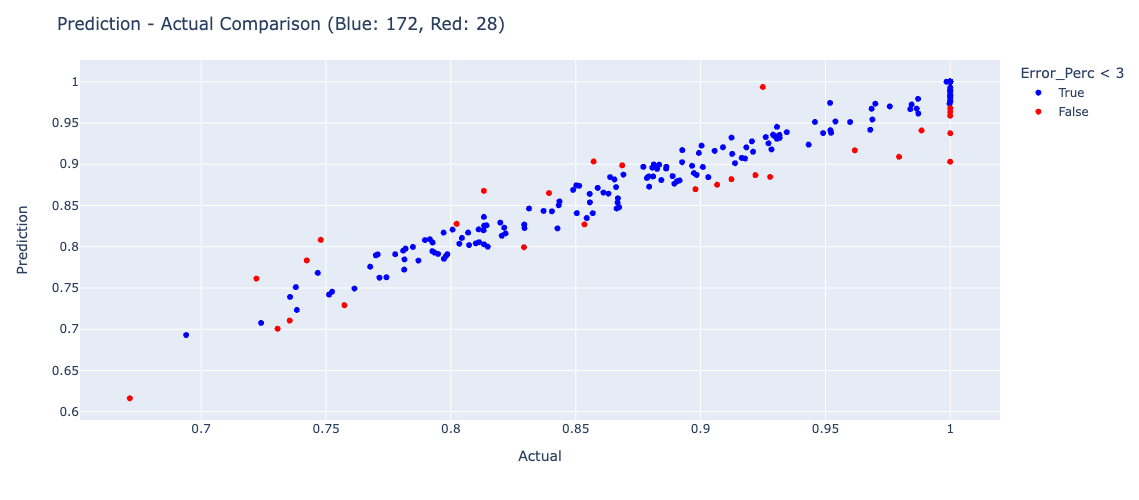

In [122]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train, batch_size = 32, epochs = 1000, verbose=1)

In [124]:
print("mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test)))
print("neg_mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test), squared=False))
print("r2:", r2_score(y_test, ann.predict(X_test)))

mean_squared_error: 0.00042069745084826816
neg_mean_squared_error: 0.020510910531916133
r2: 0.9405600915617871


In [125]:
prediction = ann.predict(X_test)

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3 
res_ann = res_ann.round(4)

res_ann

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.8238,0.8214,0.0024,0.2899,True
1,0.9521,0.9795,-0.0274,-2.8006,True
2,0.9503,0.9317,0.0185,1.9904,True
3,0.8368,0.8393,-0.0025,-0.3034,True
4,0.7955,0.7949,0.0006,0.0709,True
...,...,...,...,...,...
195,0.7912,0.8132,-0.0219,-2.6963,True
196,0.9969,1.0000,-0.0031,-0.3058,True
197,0.8329,0.8432,-0.0103,-1.2219,True
198,0.8397,0.8405,-0.0008,-0.0948,True


In [126]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

169


31

In [127]:
res_ann.describe()

,Prediction,Actual,Diff,Error_Perc
count,200.000000,200.000000,200.000000,200.000000
mean,0.876577,0.884756,-0.008181,-0.849550
std,0.078970,0.084340,0.018853,2.137320
min,0.686100,0.671400,-0.086600,-8.797600
25%,0.807900,0.813275,-0.016925,-1.881825
50%,0.871350,0.885250,-0.006550,-0.726700
75%,0.940275,0.960375,-0.000400,-0.041775
max,0.999600,1.000000,0.055500,7.597500


In [128]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9761
p-Value 0.0


In [129]:
res_ann.to_excel("Data/New/US55_DL.xlsx", index=False)

In [185]:
res_ann = pd.read_excel("Data/New/US55_DL.xlsx")

In [186]:
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1

In [187]:
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3  
res_ann = res_ann.round(4)

In [188]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

169


31

In [189]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9761
p-Value 0.0


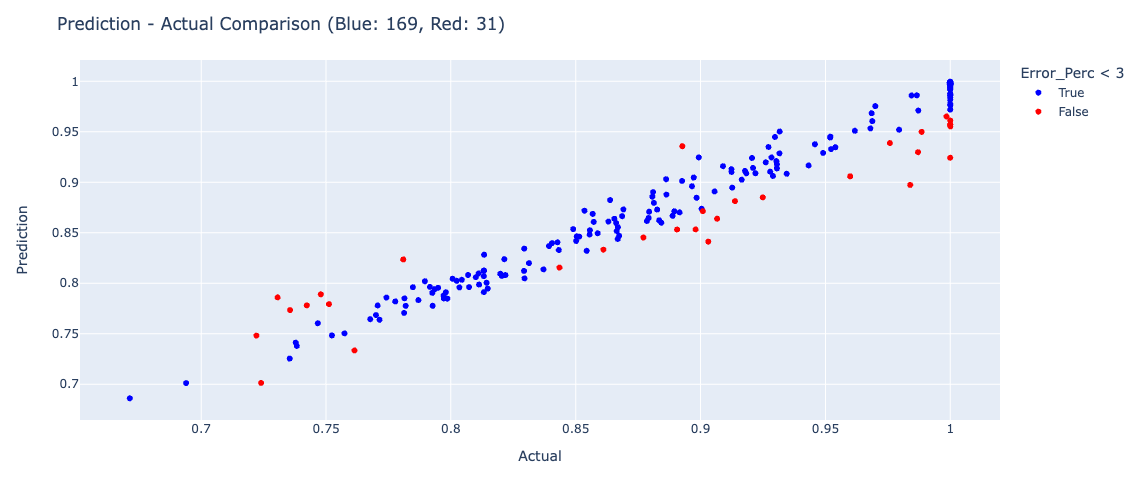

In [190]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

### S55_IO_VRS 

In [136]:
df = pd.read_excel('Data/S55.xlsx', index_col=0)
df

,Input 1,Input 2,Input 3,Input 4,Input 5,Output 1,Output 2,Output 3,Output 4,Output 5
DMU 0001,140.18,303.70,235.21,22.82,122.08,102.06,314.78,35.80,39.69,663.95
DMU 0002,147.97,263.95,125.54,29.06,162.43,100.09,329.17,61.36,37.58,645.58
DMU 0003,141.21,264.98,368.21,28.66,214.37,99.11,414.78,70.21,35.22,355.36
DMU 0004,95.55,244.37,251.49,30.25,135.42,118.90,303.65,84.49,49.91,401.68
DMU 0005,116.52,271.49,214.32,29.31,284.07,150.47,299.46,71.21,38.18,458.28
...,...,...,...,...,...,...,...,...,...,...
DMU 0996,72.58,281.46,318.09,17.55,201.11,123.54,354.28,71.85,44.15,521.31
DMU 0997,137.93,310.10,186.79,33.34,227.43,125.90,402.54,109.74,29.74,543.22
DMU 0998,124.73,244.29,361.03,25.21,153.04,108.02,415.22,82.17,47.21,618.13
DMU 0999,135.27,277.19,164.68,27.25,168.68,142.44,396.28,75.65,32.17,297.65


In [137]:
deasolver(inputfile = 'Data/S55.xlsx', folder = "Data/New/", out_suffix1="_Sol")

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [138]:
X = df
X.head()

,Input 1,Input 2,Input 3,Input 4,Input 5,Output 1,Output 2,Output 3,Output 4,Output 5
DMU 0001,140.18,303.70,235.21,22.82,122.08,102.06,314.78,35.80,39.69,663.95
DMU 0002,147.97,263.95,125.54,29.06,162.43,100.09,329.17,61.36,37.58,645.58
DMU 0003,141.21,264.98,368.21,28.66,214.37,99.11,414.78,70.21,35.22,355.36
DMU 0004,95.55,244.37,251.49,30.25,135.42,118.90,303.65,84.49,49.91,401.68
DMU 0005,116.52,271.49,214.32,29.31,284.07,150.47,299.46,71.21,38.18,458.28


In [139]:
y = pd.read_excel('Data/New/S55_Sol.xlsx', index_col=0).iloc[:,:1]
y.head()

,Efficiency_Scores
DMU 0001,0.862692
DMU 0002,0.977770
DMU 0003,0.744183
DMU 0004,0.944683
DMU 0005,0.861048


In [140]:
scaler = StandardScaler()
reg_model = LinearRegression()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0030552924086603194
neg_root_mean_squared_error: -0.05525217692959328
r2: 0.6743686538870313


In [141]:
std_scaler = StandardScaler()
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

grid = RandomizedSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0072202474753708685
neg_root_mean_squared_error: -0.08493571870236931
r2: 0.23020932303485947
grid.best_score:  -0.07811914454760542
grid.best_params:  {'decisiontreeregressor__min_samples_split': 50, 'decisiontreeregressor__max_features': 'log2', 'decisiontreeregressor__max_depth': 12}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=12, max_features='log2',
                                       min_samples_split=50,
                                       random_state=42))])
grid.r2:  0.3490216831130881


In [142]:
reg_model = KNeighborsRegressor()

pipe = make_pipeline(scaler, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0034148601711041513
neg_root_mean_squared_error: -0.05837129553756466
r2: 0.6369801838014469


In [143]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

    # Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0025031072023701272
neg_root_mean_squared_error: -0.04997692757062633
r2: 0.7330485469321194
grid.best_score:  -0.04978217527002789
grid.best_params:  {'randomforestregressor__n_estimators': 800, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100, 'randomforestregressor__bootstrap': True}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=100, min_samples_leaf=2,
                                       n_estimators=800, random_state=42))])
grid.r2:  0.7354435065096039


In [144]:
std_scaler = StandardScaler()
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0017649935211258342
neg_root_mean_squared_error: -0.04191053908769899
r2: 0.8117213797534195
-0.028487456279075136
{'gradientboostingregressor__subsample': 0.5, 'gradientboostingregressor__n_estimators': 2000, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 1, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_split=30,
                                           n_estimators=2000, random_state=42,
                                           subsample=0.5))])
r2: 0.9128570823649614


In [145]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

print("grid.best_score: ", grid.best_score_)
print("grid.best_params: ", grid.best_params_)
print("grid.best_estimator: ", grid.best_estimator_)
print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0018506869892911172
neg_root_mean_squared_error: -0.04299069605988545
r2: 0.802751106638854
grid.best_score:  -0.034340894493635254
grid.best_params:  {'xgbregressor__subsample': 0.5, 'xgbregressor__n_estimators': 500, 'xgbregressor__max_depth': 6, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.7, 'xgbregressor__colsample_bylevel': 0.7999999999999999}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.7999999999999999,
                              colsample_bynode=1, colsample_bytree=0.7,
                              enable_categorical=False, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_delta_step=0, max_depth=6,
                              min_child_weigh

In [146]:
std_scaler = StandardScaler()

poly = PolynomialFeatures(degree=3)

# Choose regression method and set hyperparameter
reg_model=LinearRegression()

pipe = make_pipeline(scaler, poly, reg_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.0009780259823022985
neg_root_mean_squared_error: -0.031162006065607768
r2: 0.896699941645906


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)

res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.7724,0.7333,0.0391,5.3254,False
1,0.9528,0.8971,0.0557,6.2078,False
2,0.9030,0.8437,0.0593,7.0299,False
3,0.8683,0.8730,-0.0047,-0.5415,True
4,0.9695,0.9231,0.0464,5.0268,False
...,...,...,...,...,...
195,0.6366,0.6624,-0.0258,-3.8976,False
196,0.7718,0.7651,0.0067,0.8702,True
197,0.8647,0.8669,-0.0021,-0.2447,True
198,1.0231,1.0000,0.0231,2.3132,True


In [148]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

145


55

In [149]:
print(res.describe())

       Prediction      Actual        Diff  Error_Perc
count  200.000000  200.000000  200.000000  200.000000
mean     0.861624    0.859270    0.002350    0.375702
std      0.097651    0.099312    0.032971    3.749968
min      0.623600    0.601800   -0.190900  -19.094800
25%      0.792275    0.788525   -0.012125   -1.468075
50%      0.854900    0.859050    0.001150    0.152550
75%      0.934450    0.935425    0.016750    2.023925
max      1.157300    1.000000    0.161300   21.292700


In [150]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9531
p-Value 0.0


In [151]:
res.to_excel("Data/New/S55_ML.xlsx", index=False)

In [152]:
res = pd.read_excel("Data/New/S55_ML.xlsx")

In [153]:
res.loc[res["Prediction"]>1, "Prediction"] = 1

In [154]:
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)

In [155]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

151


49

In [156]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9532
p-Value 0.0


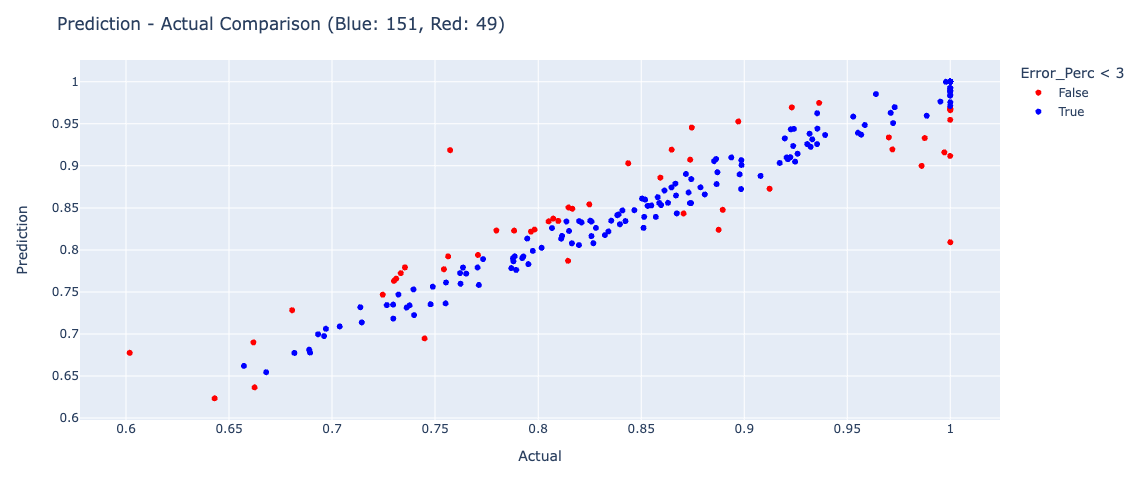

In [157]:
fig = px.scatter(res, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [ ]:
np.random.seed(1)
tf.random.set_seed(2)

ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))

ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
ann.fit(X_train, y_train, batch_size = 32, epochs = 1000, verbose=1)

In [159]:
print("mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test)))
print("neg_mean_squared_error:", mean_squared_error(y_test, ann.predict(X_test), squared=False))
print("r2:", r2_score(y_test, ann.predict(X_test)))

mean_squared_error: 0.0006722672410163108
neg_mean_squared_error: 0.025928116804278534
r2: 0.9314927909039854


In [160]:
prediction = ann.predict(X_test)

res_ann = pd.DataFrame()
res_ann["Prediction"] = pd.Series(prediction.ravel())
res_ann["Actual"] = y_test.values
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3 
res_ann = res_ann.round(4)

res_ann

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
0,0.7222,0.7333,-0.0111,-1.5160,True
1,0.8997,0.8971,0.0026,0.2934,True
2,0.8231,0.8437,-0.0206,-2.4427,True
3,0.9064,0.8730,0.0334,3.8258,False
4,0.9468,0.9231,0.0238,2.5760,True
...,...,...,...,...,...
195,0.6901,0.6624,0.0277,4.1840,False
196,0.7580,0.7651,-0.0071,-0.9256,True
197,0.8832,0.8669,0.0163,1.8787,True
198,1.0051,1.0000,0.0051,0.5096,True


In [161]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

148


52

In [162]:
res_ann.describe()

,Prediction,Actual,Diff,Error_Perc
count,200.000000,200.000000,200.000000,200.000000
mean,0.859809,0.859270,0.000533,0.206752
std,0.092042,0.099312,0.025987,3.025176
min,0.652000,0.601800,-0.111400,-11.144700
25%,0.795175,0.788525,-0.012675,-1.416950
50%,0.860550,0.859050,0.002350,0.248200
75%,0.938350,0.935425,0.017025,2.140825
max,1.010300,1.000000,0.066200,8.995400


In [163]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9657
p-Value 0.0


In [164]:
res_ann.to_excel("Data/New/S55_DL.xlsx", index=False)

In [178]:
res_ann = pd.read_excel("Data/New/S55_DL.xlsx")

In [179]:
res_ann.loc[res_ann["Prediction"]>1, "Prediction"] = 1

In [180]:
res_ann.Prediction.describe()

count    200.000000
mean       0.859458
std        0.091494
min        0.652000
25%        0.795175
50%        0.860550
75%        0.938350
max        1.000000
Name: Prediction, dtype: float64

In [181]:
res_ann["Diff"] = res_ann.Prediction - res_ann.Actual
res_ann["Error_Perc"] = ((res_ann.Prediction - res_ann.Actual) / res_ann.Actual) * 100 
res_ann["Error_Perc < 3"] = np.abs(res_ann["Error_Perc"]) < 3  
res_ann = res_ann.round(4)

In [182]:
blue = res_ann["Error_Perc < 3"].sum()
print(blue)
red = len(res_ann["Error_Perc < 3"]) - (res_ann["Error_Perc < 3"].sum())
red

148


52

In [183]:
rho, p = stats.spearmanr(res_ann.Prediction, res_ann.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9657
p-Value 0.0


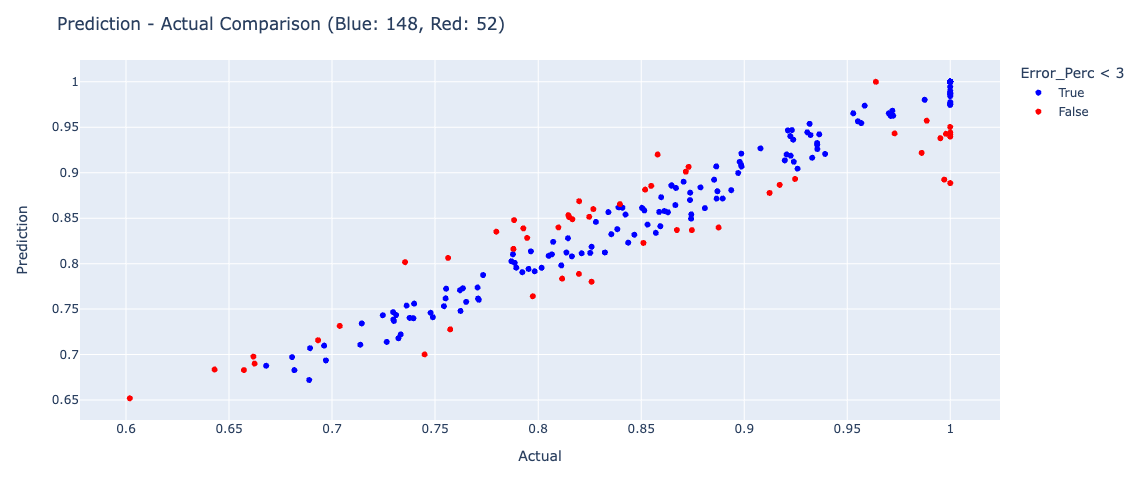

In [184]:
fig = px.scatter(res_ann, x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()